IMPORTING LIBRARIES

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

LOAD DATASET

In [60]:
house_data=pd.read_csv(r"C:\Users\jayat\OneDrive\Documents\Downloads\Housing - Housing.csv.csv")

In [61]:
house_data.sample(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
44,7560000,6000,4,2,4,yes,no,no,no,yes,1,no,furnished
352,3780000,5830,2,1,1,yes,no,no,no,no,2,no,unfurnished
86,6510000,6670,3,1,3,yes,no,yes,no,no,0,yes,unfurnished
510,2520000,2880,3,1,1,no,no,no,no,no,0,no,unfurnished
210,4900000,4646,3,1,2,yes,yes,yes,no,no,2,no,semi-furnished


In [62]:
print("Dataset Shape:",house_data.shape)

Dataset Shape: (545, 13)


In [63]:
print("Missing rows:", house_data.isnull().sum().sum())
print("Duplicate rows:", house_data.duplicated().sum())

Missing rows: 0
Duplicate rows: 0


In [64]:
#binary categorical data
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_cols:
    house_data[col]=house_data[col].map({'yes': 1, 'no': 0}).astype(int)

#ordinal encoding
house_data['furnishingstatus'] = house_data['furnishingstatus'].map({
    'unfurnished': 0,
    'semi-furnished': 1,
    'furnished': 2
}).astype(int)

In [65]:
house_data.dtypes

price               int64
area                int64
bedrooms            int64
bathrooms           int64
stories             int64
mainroad            int32
guestroom           int32
basement            int32
hotwaterheating     int32
airconditioning     int32
parking             int64
prefarea            int32
furnishingstatus    int32
dtype: object

EXPLORATORY DATA ANALYSIS

In [66]:
print(house_data.info())
print(house_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int32
 6   guestroom         545 non-null    int32
 7   basement          545 non-null    int32
 8   hotwaterheating   545 non-null    int32
 9   airconditioning   545 non-null    int32
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int32
 12  furnishingstatus  545 non-null    int32
dtypes: int32(7), int64(6)
memory usage: 40.6 KB
None
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06 

NUMERIC COLS

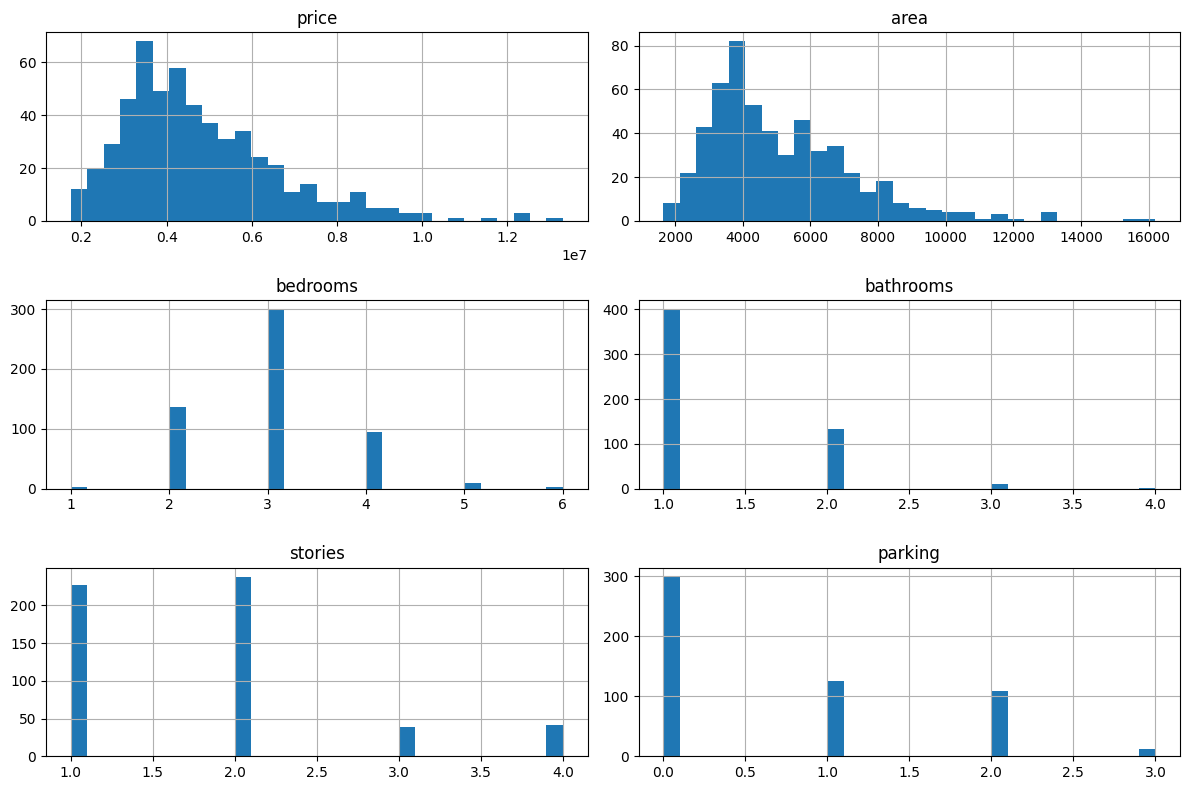

In [67]:
numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
house_data[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

CORRELATION HEATMAP

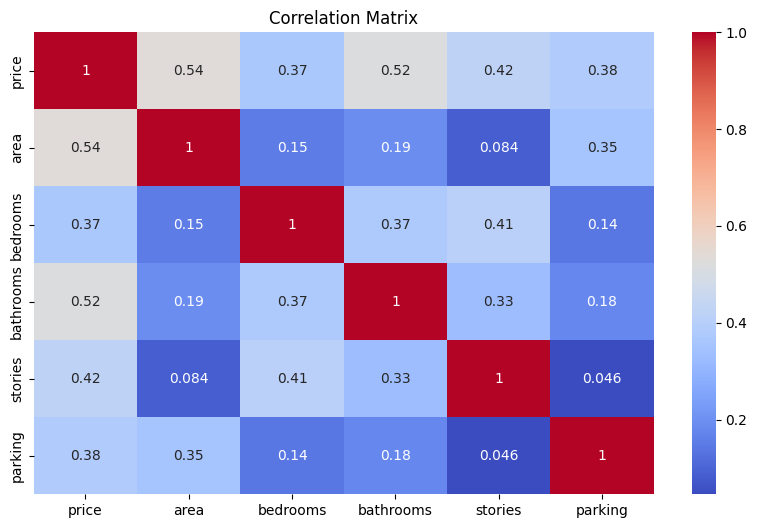

In [68]:
plt.figure(figsize=(10, 6))
sns.heatmap(house_data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

BOXPLOT FOR OUTLIER DETECTION

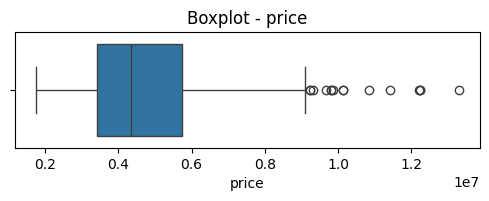

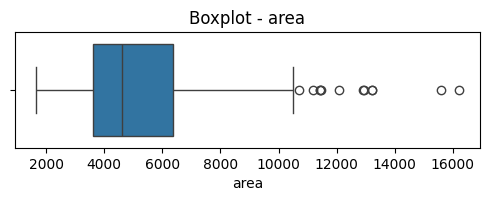

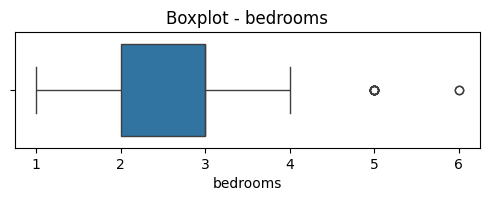

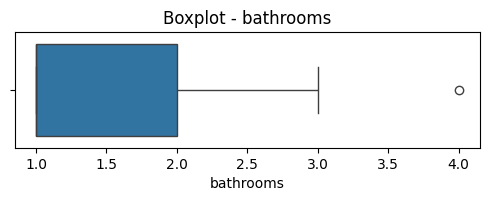

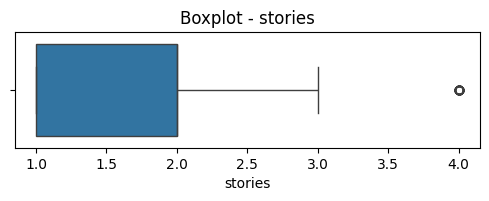

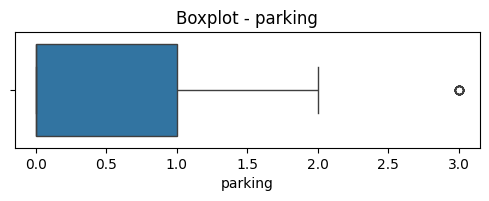

In [69]:
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=house_data[col])
    plt.title(f'Boxplot - {col}')
    plt.show()

OUTLIER REMOVAL (IQR METHOD)

In [70]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in ['area', 'price']:
    house_data = remove_outliers_iqr(house_data, col)

FEATURE ENGINEERING

In [71]:
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
house_data[binary_cols] = house_data[binary_cols].replace({'yes': 1, 'no': 0})

TRAIN-TEST-SPLIT

In [79]:
x = house_data.drop('price', axis=1)
y = house_data['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


ONE-HOT ENCODE

In [80]:
x_encoded = pd.get_dummies(x, drop_first=True)

FEATURE SCALING

In [81]:
scale_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
scaler = StandardScaler()
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])
x_test[scale_cols] = scaler.transform(x_test[scale_cols])

MODEL TRAINING AND EVALUATION

In [83]:
lr = LinearRegression()
lasso = Lasso(random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
svr = SVR()
xgb = XGBRegressor(random_state=42)

models = {
    'Linear Regression': lr,
    'Lasso Regression': lasso,
    'Decision Tree Regression': dt_reg,
    'Gradient Boosting Regression': gbr,
    'Random Forest Regressor': rf,
    'SVR': svr,
    'XGBoost': xgb
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2 Score': r2})
    print(f"{name} - RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")

Linear Regression - RMSE: 967597.99, R2 Score: 0.7140
Lasso Regression - RMSE: 967598.55, R2 Score: 0.7140
Decision Tree Regression - RMSE: 1190189.82, R2 Score: 0.5673
Gradient Boosting Regression - RMSE: 898221.42, R2 Score: 0.7535
Random Forest Regressor - RMSE: 946648.18, R2 Score: 0.7262
SVR - RMSE: 1849549.42, R2 Score: -0.0450
XGBoost - RMSE: 920883.45, R2 Score: 0.7409


COMPARISON VISUALIZATION

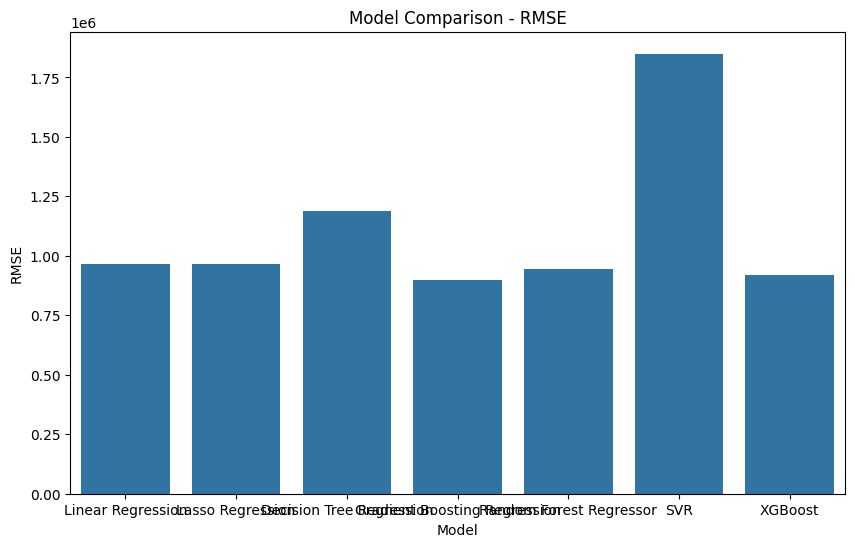

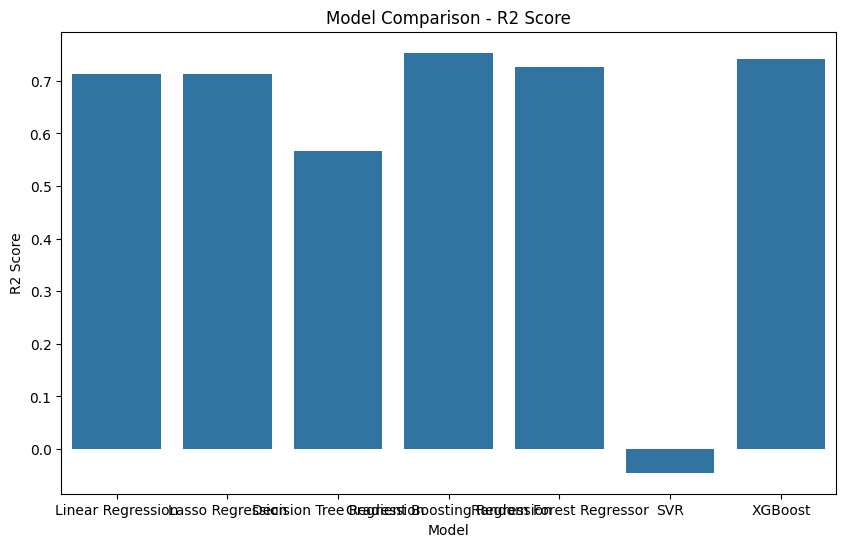

In [84]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title("Model Comparison - RMSE")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='R2 Score')
plt.title("Model Comparison - R2 Score")
plt.show()

FEATURE IMPORTANCE FROM BEST MODEL(XGBOOST)

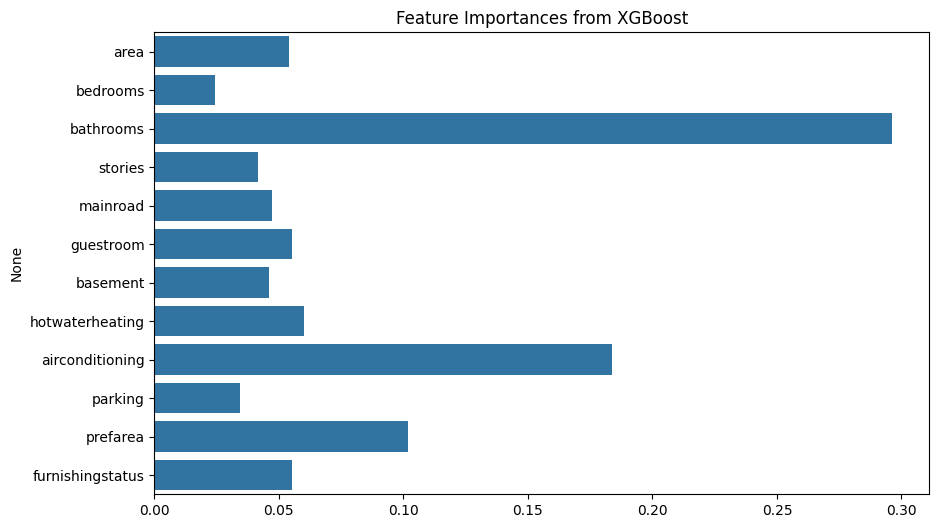

In [86]:
best_model = models['XGBoost']
importance = best_model.feature_importances_
features = x.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.title("Feature Importances from XGBoost")
plt.show()

ACTUAL VS PREDICTED FOR THE BEST MODEL

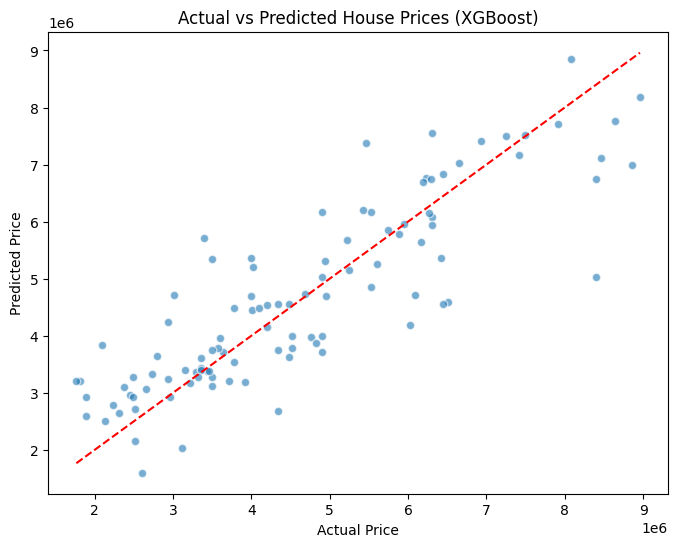

In [88]:
y_pred = best_model.predict(x_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices (XGBoost)")
plt.show()


SAVE BEST MODEL AND SCALER

In [89]:
best_model = models['XGBoost']
import joblib
joblib.dump(best_model, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']